In [1]:
from pycaret.regression import * 
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv("train.csv")

In [3]:
raw_data.shape

(36581, 16)

In [4]:
need = ["상대 습도 (%)","섭씨 온도(°⁣C)","대기압(mbar)","공기 밀도 (g/m**3)","수증기 함량 (g/kg)","풍향 (deg)"]

In [5]:
all = need.copy()
all.append("풍속 (m/s)")

In [6]:
# SWAP 노이즈를 주기 위해 월별, 시간대로 데이터를 모음
dict_temp = {
    "오후" : [],
    "저녁" : [],
    "오전" : [],
    "새벽" : [],
}

humid_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["상대 습도 (%)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    humid_dict[i] = temp_

temp_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["섭씨 온도(°⁣C)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    temp_dict[i] = temp_

mbar_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["대기압(mbar)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    mbar_dict[i] = temp_

gm_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["공기 밀도 (g/m**3)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    gm_dict[i] = temp_

gkg_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["수증기 함량 (g/kg)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    gkg_dict[i] = temp_

deg_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["풍향 (deg)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    deg_dict[i] = temp_
    

In [7]:
def make_noise(iter = 1):
    # Swap noise를 적용하는 함수를 수정하여 10% 확률로 swap합니다.
    def add_swap_noise(input_data, num_iterations=36581):
        data_mix = np.array(input_data)
        swap_probability = 0.15
        
        for _ in range(num_iterations):
            if np.random.random() <= swap_probability:
                while True:
                    idx1 = np.random.randint(0, data_mix.shape[0])
                    idx2 = np.random.randint(0, data_mix.shape[0])
                    if idx1 != idx2:
                        break
                data_mix[idx1], data_mix[idx2] = data_mix[idx2], data_mix[idx1]  # 값 교환
        return data_mix
    res_noisy_df = pd.DataFrame()
    for _ in range(iter):
        # Noisy 데이터를 DataFrame에 저장
        noisy_df = raw_data.copy()
        all_dicts = [humid_dict, temp_dict, mbar_dict, gm_dict, gkg_dict, deg_dict]

        for column, dictionary in zip(need, all_dicts):
            for month in range(1, 13):
                for time_of_day, row_indices in dict_temp.items():
                    mask = (noisy_df['월'] == month) & (noisy_df['측정 시간대'] == time_of_day)
                    original_data = raw_data.loc[mask, column].values
                    if len(original_data) > 0:
                        noisy_data = add_swap_noise(original_data)
                        noisy_df.loc[mask, column] = noisy_data

        res_noisy_df = pd.concat([res_noisy_df,noisy_df])

    return res_noisy_df.reset_index()

In [8]:
res_noisy_df = make_noise(1)

In [10]:
test_data = raw_data[all].sample(int(raw_data.shape[0]*0.2)).reset_index().drop("index",axis=1)

In [11]:
datas = res_noisy_df[all]

In [12]:
reg = setup(datas, test_data=test_data, target = '풍속 (m/s)',normalize=True,normalize_method="zscore",index=False)

,Description,Value
0,Session id,1380
1,Target,풍속 (m/s)
2,Target type,Regression
3,Original data shape,"(80478, 7)"
4,Transformed data shape,"(80478, 7)"
5,Transformed train set shape,"(73162, 7)"
6,Transformed test set shape,"(7316, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [14]:
top5 = compare_models(n_select = 5, sort = 'MAE')


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:06:35
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,AdaBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.0817,2.3505,1.5330,0.0141,0.4397,0.8615,0.0530
lr,Linear Regression,1.1227,2.2613,1.5036,0.0515,0.4514,1.0270,0.0350
ridge,Ridge Regression,1.1227,2.2613,1.5036,0.0515,0.4514,1.0270,0.0310
lar,Least Angle Regression,1.1227,2.2613,1.5036,0.0515,0.4514,1.0270,0.0180
br,Bayesian Ridge,1.1227,2.2613,1.5036,0.0515,0.4514,1.0271,0.0210
omp,Orthogonal Matching Pursuit,1.1402,2.3370,1.5286,0.0198,0.4590,1.0560,0.0300
rf,Random Forest Regressor,1.1435,2.3055,1.5182,0.0329,0.4585,1.0493,4.5890
et,Extra Trees Regressor,1.1479,2.3273,1.5254,0.0237,0.4605,1.0528,1.7440
lasso,Lasso Regression,1.1580,2.3844,1.5440,-0.0001,0.4654,1.0845,0.0320
en,Elastic Net,1.1580,2.3844,1.5440,-0.0001,0.4654,1.0845,0.0340


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1140,2.2413,1.4971,0.0559,0.4464,0.9893
1,1.1211,2.2813,1.5104,0.0507,0.4514,1.0118
2,1.1137,2.2527,1.5009,0.0641,0.4476,0.9959
3,1.1068,2.2249,1.4916,0.0599,0.4448,0.9880
4,1.1160,2.2066,1.4855,0.0632,0.4475,1.0042
5,1.1136,2.2689,1.5063,0.0618,0.4466,0.9879
6,1.1147,2.2621,1.5040,0.0574,0.4485,1.0062
7,1.1007,2.1578,1.4689,0.0574,0.4456,0.9979
8,1.1249,2.2882,1.5127,0.0589,0.4491,0.9974


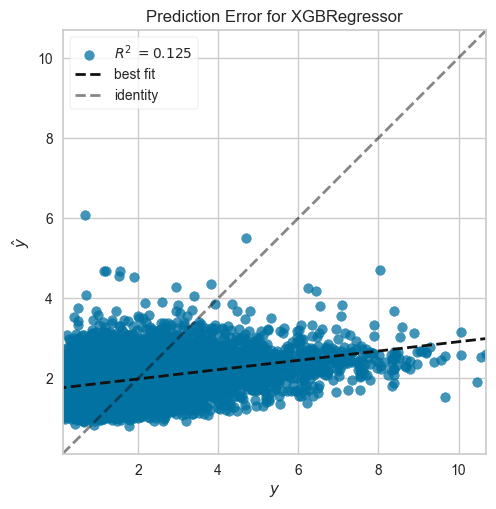

In [ ]:
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

In [ ]:
voting = finalize_model(voting)


NameError: name 'best_model' is not defined